Universidad del Valle de Guatemala  
Departamento de Ciencias de la Computación  
Inteligencia Artificial - sección 10  

Laboratorio 4

Nadissa Vela - 23764  
Cristian Túnchez - 231359

---

# Task 2.1

**Importar librerías**

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 1. Generación de Datos

### a. Generar 1000 puntos de datos basados en y = 2x³ - 3x² + 5x + 3

In [76]:
# Configurar semilla para reproducibilidad
np.random.seed(42)

n_points = 1000

# Generar valores de x en un rango razonable
x = np.linspace(-2, 3, n_points)

# Calcular y usando la función polinomial: y = 2x³ - 3x² + 5x + 3
y_real = 2 * x**3 - 3 * x**2 + 5 * x + 3

print(f"Generados {n_points} puntos de datos")
print(f"Rango de x: [{x.min():.2f}, {x.max():.2f}]")
print(f"Rango de y_real: [{y_real.min():.2f}, {y_real.max():.2f}]")

Generados 1000 puntos de datos
Rango de x: [-2.00, 3.00]
Rango de y_real: [-35.00, 45.00]


### b. Agregar ruido aleatorio normal a y

In [77]:
# El ruido será proporcional a la desviación estándar de y_real
noise_level = 0.15  # 15% de ruido
std_y = np.std(y_real)
noise = np.random.normal(0, noise_level * std_y, n_points)

# y con ruido
y_noisy = y_real + noise

print(f"Desviación estándar del ruido: {np.std(noise):.4f}")
print(f"Rango de y con ruido: [{y_noisy.min():.2f}, {y_noisy.max():.2f}]")

Desviación estándar del ruido: 2.4378
Rango de y con ruido: [-37.16, 48.87]


### c. Normalizar los datos

In [78]:
# Guardamos los parámetros de normalización para poder desnormalizar después
x_mean, x_std = np.mean(x), np.std(x)
y_mean, y_std = np.mean(y_noisy), np.std(y_noisy)

# Normalización z-score: (valor - media) / desviación estándar
x_normalized = (x - x_mean) / x_std
y_normalized = (y_noisy - y_mean) / y_std

print("Datos normalizados:")
print(f"x_normalized - Media: {np.mean(x_normalized):.6f}, Std: {np.std(x_normalized):.6f}")
print(f"y_normalized - Media: {np.mean(y_normalized):.6f}, Std: {np.std(y_normalized):.6f}")
print("\nParámetros de normalización guardados:")
print(f"x: media={x_mean:.4f}, std={x_std:.4f}")
print(f"y: media={y_mean:.4f}, std={y_std:.4f}")

Datos normalizados:
x_normalized - Media: -0.000000, Std: 1.000000
y_normalized - Media: 0.000000, Std: 1.000000

Parámetros de normalización guardados:
x: media=0.5000, std=1.4448
y: media=5.0482, std=16.8836


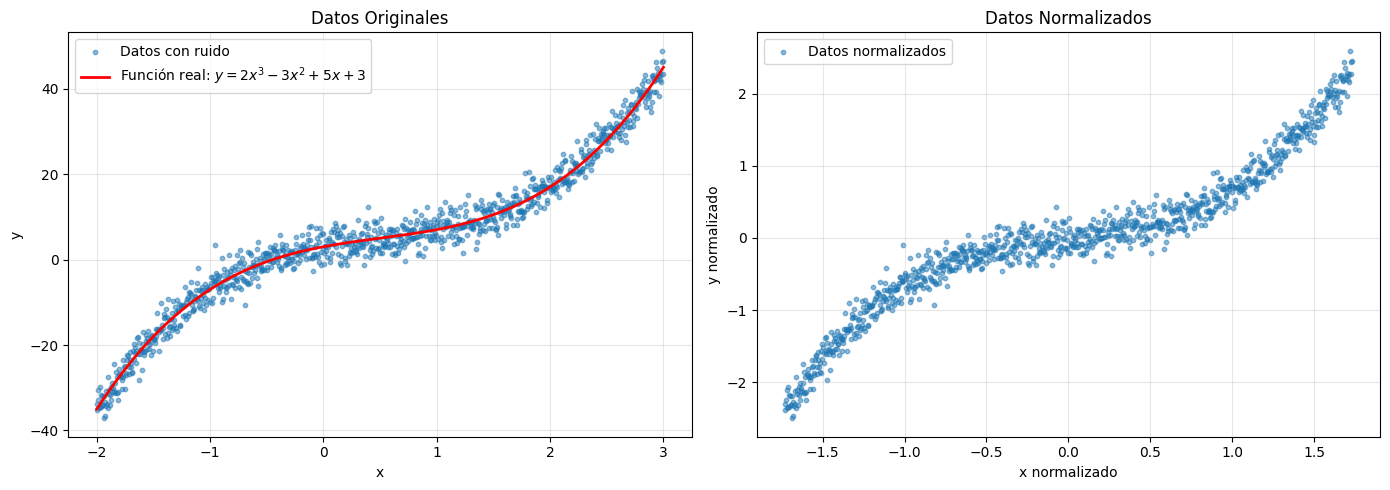


Datos listos para entrenar modelos de regresión polinomial.


In [79]:
# Visualizar los datos generados
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Subplot 1: Datos originales (con ruido)
axes[0].scatter(x, y_noisy, alpha=0.5, s=10, label='Datos con ruido')
axes[0].plot(x, y_real, 'r-', linewidth=2, label='Función real: $y = 2x^3 - 3x^2 + 5x + 3$')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_title('Datos Originales')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Subplot 2: Datos normalizados
axes[1].scatter(x_normalized, y_normalized, alpha=0.5, s=10, label='Datos normalizados')
axes[1].set_xlabel('x normalizado')
axes[1].set_ylabel('y normalizado')
axes[1].set_title('Datos Normalizados')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nDatos listos para entrenar modelos de regresión polinomial.")

## 2. Implementación de Algoritmos

**Funciones auxiliares**

In [80]:
# Primero implementamos funciones para calcular la predicción y el gradiente del polinomio de grado 3.
def create_polynomial_features(x, degree=3):
    """
    Crea la matriz de características polinomiales.
    Para grado 3: [1, x, x², x³]
    
    Args:
        x: array de entrada (n_samples,)
        degree: grado del polinomio
    
    Returns:
        X: matriz de características (n_samples, degree+1)
    """
    n = len(x)
    X = np.ones((n, degree + 1))
    
    for i in range(1, degree + 1):
        X[:, i] = x ** i
    
    return X


def predict_polynomial(X, weights):
    """
    Calcula las predicciones del modelo polinomial.
    y_pred = w₀ + w₁x + w₂x² + w₃x³
    
    Args:
        X: matriz de características (n_samples, degree+1)
        weights: vector de pesos (degree+1,)
    
    Returns:
        y_pred: predicciones (n_samples,)
    """
    return X @ weights


def compute_gradient(X, y, weights):
    """
    Calcula el gradiente de la función de costo MSE.
    
    Para MSE: J = (1/m) * Σ(y_pred - y)²
    Gradiente: ∂J/∂w_j = (2/m) * Σ(y_pred - y) * x_j
    
    En forma vectorial: ∇J = (2/m) * X^T * (y_pred - y)
    
    Args:
        X: matriz de características (n_samples, degree+1)
        y: valores reales (n_samples,)
        weights: vector de pesos (degree+1,)
    
    Returns:
        gradient: vector de gradientes (degree+1,)
    """
    m = len(y)
    y_pred = predict_polynomial(X, weights)
    error = y_pred - y
    gradient = (2 / m) * (X.T @ error)
    return gradient


def compute_mse(X, y, weights):
    """
    Calcula el error cuadrático medio (MSE).
    
    Args:
        X: matriz de características
        y: valores reales
        weights: vector de pesos
    
    Returns:
        mse: error cuadrático medio
    """
    y_pred = predict_polynomial(X, weights)
    mse = np.mean((y_pred - y) ** 2)
    return mse


# Probar las funciones auxiliares
X_train = create_polynomial_features(x_normalized, degree=3)
print(f"Forma de la matriz de características: {X_train.shape}")
print("Primeras 5 filas de X_train:")
print(X_train[:5])

# Inicializar pesos aleatorios
weights_test = np.random.randn(4) * 0.01
print(f"\nPesos de prueba: {weights_test}")
print(f"MSE inicial: {compute_mse(X_train, y_normalized, weights_test):.4f}")

Forma de la matriz de características: (1000, 4)
Primeras 5 filas de X_train:
[[ 1.         -1.73031962  2.99400599 -5.18058732]
 [ 1.         -1.72685552  2.98202998 -5.14953493]
 [ 1.         -1.72339142  2.97007797 -5.11860688]
 [ 1.         -1.71992731  2.95814996 -5.08780291]
 [ 1.         -1.71646321  2.94624595 -5.05712277]]

Pesos de prueba: [ 0.01399355  0.00924634  0.0005963  -0.00646937]
MSE inicial: 1.0077


### a. Batch Gradient Descent

In [81]:
def batch_gradient_descent(X, y, learning_rate=0.01, n_iterations=1000, verbose=False):
    """
    Implementación de Batch Gradient Descent.
    Usa TODOS los datos en cada paso para calcular el gradiente.
    
    Args:
        X: matriz de características (n_samples, n_features)
        y: valores objetivo (n_samples,)
        learning_rate: tasa de aprendizaje (η)
        n_iterations: número de iteraciones
        verbose: imprime información durante el entrenamiento
    
    Returns:
        weights: pesos finales
        history: diccionario con el historial de costo y pesos
    """
    n_features = X.shape[1]
    
    # Inicializar pesos aleatoriamente (pequeños valores)
    weights = np.random.randn(n_features) * 0.01
    
    # Historia del entrenamiento
    history = {
        'cost': [],
        'weights': []
    }
    
    # Iteraciones de entrenamiento
    for iteration in range(n_iterations):
        # Calcular gradiente usando TODOS los datos
        gradient = compute_gradient(X, y, weights)
        
        # Actualizar pesos: w = w - η * ∇J
        weights = weights - learning_rate * gradient
        
        # Guardar el costo
        cost = compute_mse(X, y, weights)
        history['cost'].append(cost)
        history['weights'].append(weights.copy())
        
        # Imprimir progreso
        if verbose and (iteration % 100 == 0 or iteration == n_iterations - 1):
            print(f"Iteración {iteration:4d}: MSE = {cost:.6f}")
    
    return weights, history

print("Función de batch gradient descent implementada correctamente.")

Función de batch gradient descent implementada correctamente.


### b. Stochastic Gradient Descent (SGD)

In [82]:
def stochastic_gradient_descent(X, y, learning_rate=0.01, n_iterations=1000, 
                            random_seed=None, verbose=False):
    """
    Implementación de Stochastic Gradient Descent (SGD).
    Usa UN SOLO dato aleatorio en cada paso para calcular el gradiente.
    
    Args:
        X: matriz de características (n_samples, n_features)
        y: valores objetivo (n_samples,)
        learning_rate: tasa de aprendizaje (η)
        n_iterations: número de iteraciones
        random_seed: semilla para reproducibilidad
        verbose: imprime información durante el entrenamiento
    
    Returns:
        weights: pesos finales
        history: diccionario con el historial de costo y pesos
    """
    if random_seed is not None:
        np.random.seed(random_seed)
    
    n_samples, n_features = X.shape
    
    # Inicializar pesos aleatoriamente
    weights = np.random.randn(n_features) * 0.01
    
    # Historia del entrenamiento
    history = {
        'cost': [],
        'weights': []
    }
    
    # Iteraciones de entrenamiento
    for iteration in range(n_iterations):
        # Seleccionar UN dato aleatorio
        idx = np.random.randint(0, n_samples)
        X_sample = X[idx:idx+1]  # Shape (1, n_features)
        y_sample = y[idx:idx+1]  # Shape (1,)
        
        # Calcular gradiente usando SOLO este dato
        gradient = compute_gradient(X_sample, y_sample, weights)
        
        # Actualizar pesos: w = w - η * ∇J
        weights = weights - learning_rate * gradient
        
        # Calcular costo en TODO el dataset (para monitoreo)
        cost = compute_mse(X, y, weights)
        history['cost'].append(cost)
        history['weights'].append(weights.copy())
        
        # Imprimir progreso
        if verbose and (iteration % 100 == 0 or iteration == n_iterations - 1):
            print(f"Iteración {iteration:4d}: MSE = {cost:.6f}")
    
    return weights, history

print("Función de stochastic gradient descent implementada correctamente.")

Función de stochastic gradient descent implementada correctamente.


### c. Mini-batch Gradient Descent

In [83]:
def minibatch_gradient_descent(X, y, learning_rate=0.01, n_iterations=1000, 
                            batch_size=32, random_seed=None, verbose=False):
    """
    Implementación de Mini-batch Gradient Descent.
    Usa un LOTE de n datos en cada paso para calcular el gradiente.
    
    Args:
        X: matriz de características (n_samples, n_features)
        y: valores objetivo (n_samples,)
        learning_rate: tasa de aprendizaje (η)
        n_iterations: número de iteraciones
        batch_size: tamaño del lote (mini-batch)
        random_seed: semilla para reproducibilidad
        verbose: imprime información durante el entrenamiento
    
    Returns:
        weights: pesos finales
        history: diccionario con el historial de costo y pesos
    """
    if random_seed is not None:
        np.random.seed(random_seed)
    
    n_samples, n_features = X.shape
    
    # Inicializar pesos aleatoriamente
    weights = np.random.randn(n_features) * 0.01
    
    # Historia del entrenamiento
    history = {
        'cost': [],
        'weights': []
    }
    
    # Iteraciones de entrenamiento
    for iteration in range(n_iterations):
        # Seleccionar un mini-batch aleatorio
        indices = np.random.choice(n_samples, size=batch_size, replace=False)
        X_batch = X[indices]
        y_batch = y[indices]
        
        # Calcular gradiente usando el mini-batch
        gradient = compute_gradient(X_batch, y_batch, weights)
        
        # Actualizar pesos: w = w - η * ∇J
        weights = weights - learning_rate * gradient
        
        # Calcular costo en TODO el dataset (para monitoreo)
        cost = compute_mse(X, y, weights)
        history['cost'].append(cost)
        history['weights'].append(weights.copy())
        
        # Imprimir progreso
        if verbose and (iteration % 100 == 0 or iteration == n_iterations - 1):
            print(f"Iteración {iteration:4d}: MSE = {cost:.6f}")
    
    return weights, history

print("Función de mini-batch gradient descent implementada correctamente.")

Función de mini-batch gradient descent implementada correctamente.


## 3. Experimentación y Análisis

### a. Entrenar los tres modelos

In [84]:
import time

def train_with_time_tracking(train_function, X, y, **kwargs):
    """
    Función wrapper que entrena un modelo y registra el tiempo de cada iteración.
    
    Args:
        train_function: función de entrenamiento (BGD, SGD, o MBGD)
        X: matriz de características
        y: valores objetivo
        **kwargs: argumentos adicionales para la función de entrenamiento
    
    Returns:
        weights: pesos finales
        history: historial con cost, weights y timestamps
    """
    n_iterations = kwargs.get('n_iterations', 1000)
    n_features = X.shape[1]
    
    # Inicializar pesos
    if 'random_seed' in kwargs:
        np.random.seed(kwargs['random_seed'])
    weights = np.random.randn(n_features) * 0.01
    
    # Historia con timestamps
    history = {
        'cost': [],
        'weights': [],
        'time': []
    }
    
    start_time = time.time()
    
    # Determinar qué función usar y entrenar
    if train_function.__name__ == 'batch_gradient_descent':
        for iteration in range(n_iterations):
            gradient = compute_gradient(X, y, weights)
            weights = weights - kwargs['learning_rate'] * gradient
            
            cost = compute_mse(X, y, weights)
            current_time = time.time() - start_time
            
            history['cost'].append(cost)
            history['weights'].append(weights.copy())
            history['time'].append(current_time)
    
    elif train_function.__name__ == 'stochastic_gradient_descent':
        n_samples = X.shape[0]
        for iteration in range(n_iterations):
            idx = np.random.randint(0, n_samples)
            X_sample = X[idx:idx+1]
            y_sample = y[idx:idx+1]
            
            gradient = compute_gradient(X_sample, y_sample, weights)
            weights = weights - kwargs['learning_rate'] * gradient
            
            cost = compute_mse(X, y, weights)
            current_time = time.time() - start_time
            
            history['cost'].append(cost)
            history['weights'].append(weights.copy())
            history['time'].append(current_time)
    
    elif train_function.__name__ == 'minibatch_gradient_descent':
        n_samples = X.shape[0]
        batch_size = kwargs.get('batch_size', 32)
        
        for iteration in range(n_iterations):
            indices = np.random.choice(n_samples, size=batch_size, replace=False)
            X_batch = X[indices]
            y_batch = y[indices]
            
            gradient = compute_gradient(X_batch, y_batch, weights)
            weights = weights - kwargs['learning_rate'] * gradient
            
            cost = compute_mse(X, y, weights)
            current_time = time.time() - start_time
            
            history['cost'].append(cost)
            history['weights'].append(weights.copy())
            history['time'].append(current_time)
    
    history['total_time'] = time.time() - start_time
    
    return weights, history

print("Función de entrenamiento con seguimiento de tiempo lista.")

Función de entrenamiento con seguimiento de tiempo lista.


In [85]:
# Configuración de entrenamiento (mismos parámetros para todos)
n_epochs = 2000
random_seed = 42

print("="*80)
print("ENTRENANDO LOS TRES ALGORITMOS")
print("="*80)

# 1. Batch Gradient Descent
print("\n1. Entrenando Batch Gradient Descent...")
np.random.seed(random_seed)
weights_bgd, history_bgd = train_with_time_tracking(
    batch_gradient_descent,
    X_train, y_normalized,
    learning_rate=0.1,
    n_iterations=n_epochs,
    random_seed=random_seed
)
print(f"   Tiempo total: {history_bgd['total_time']:.4f} segundos")
print(f"   MSE final: {history_bgd['cost'][-1]:.6f}")

# 2. Stochastic Gradient Descent
print("\n2. Entrenando Stochastic Gradient Descent...")
np.random.seed(random_seed)
weights_sgd, history_sgd = train_with_time_tracking(
    stochastic_gradient_descent,
    X_train, y_normalized,
    learning_rate=0.01,
    n_iterations=n_epochs,
    random_seed=random_seed
)
print(f"   Tiempo total: {history_sgd['total_time']:.4f} segundos")
print(f"   MSE final: {history_sgd['cost'][-1]:.6f}")

# 3. Mini-batch Gradient Descent
print("\n3. Entrenando Mini-batch Gradient Descent...")
np.random.seed(random_seed)
weights_mbgd, history_mbgd = train_with_time_tracking(
    minibatch_gradient_descent,
    X_train, y_normalized,
    learning_rate=0.05,
    n_iterations=n_epochs,
    batch_size=32,
    random_seed=random_seed
)
print(f"   Tiempo total: {history_mbgd['total_time']:.4f} segundos")
print(f"   MSE final: {history_mbgd['cost'][-1]:.6f}")

print("\n" + "="*80)
print("ENTRENAMIENTO COMPLETADO")
print("="*80)

ENTRENANDO LOS TRES ALGORITMOS

1. Entrenando Batch Gradient Descent...
   Tiempo total: 0.0720 segundos
   MSE final: 0.020804

2. Entrenando Stochastic Gradient Descent...
   Tiempo total: 0.0629 segundos
   MSE final: 0.022256

3. Entrenando Mini-batch Gradient Descent...
   Tiempo total: 0.1414 segundos
   MSE final: 0.020912

ENTRENAMIENTO COMPLETADO


### b. Gráfica de Convergencia: Costo vs Tiempo (segundos)

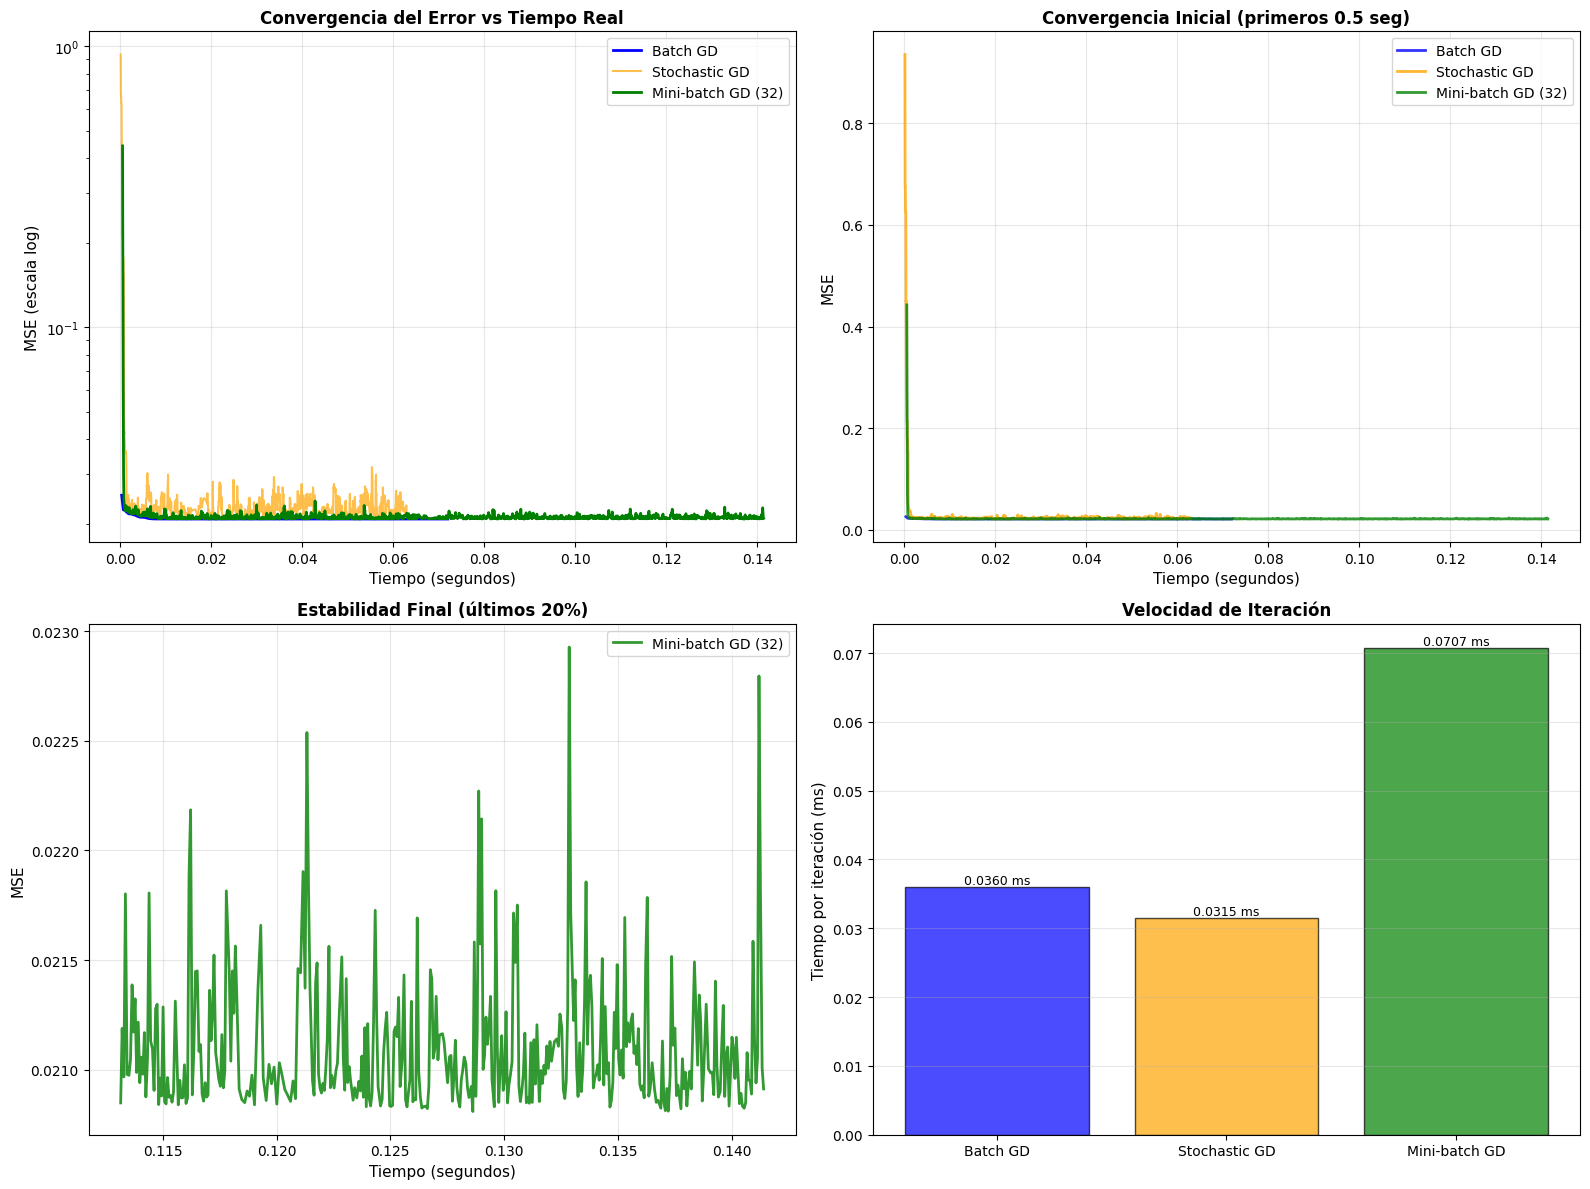

In [86]:
# Crear gráficas de convergencia usando TIEMPO REAL en el eje X
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Convergencia completa (escala logarítmica)
ax1 = axes[0, 0]
ax1.plot(history_bgd['time'], history_bgd['cost'], label='Batch GD', linewidth=2, color='blue')
ax1.plot(history_sgd['time'], history_sgd['cost'], label='Stochastic GD', alpha=0.7, color='orange')
ax1.plot(history_mbgd['time'], history_mbgd['cost'], label='Mini-batch GD (32)', linewidth=2, color='green')
ax1.set_xlabel('Tiempo (segundos)', fontsize=11)
ax1.set_ylabel('MSE (escala log)', fontsize=11)
ax1.set_title('Convergencia del Error vs Tiempo Real', fontsize=12, fontweight='bold')
ax1.set_yscale('log')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# 2. Primeros segundos (zoom in)
ax2 = axes[0, 1]
time_cutoff = 0.5  # Primeros 0.5 segundos
for hist, label, color in [(history_bgd, 'Batch GD', 'blue'), 
                            (history_sgd, 'Stochastic GD', 'orange'),
                            (history_mbgd, 'Mini-batch GD (32)', 'green')]:
    mask = np.array(hist['time']) <= time_cutoff
    if np.any(mask):
        ax2.plot(np.array(hist['time'])[mask], np.array(hist['cost'])[mask], 
                label=label, linewidth=2, color=color, alpha=0.8)

ax2.set_xlabel('Tiempo (segundos)', fontsize=11)
ax2.set_ylabel('MSE', fontsize=11)
ax2.set_title(f'Convergencia Inicial (primeros {time_cutoff} seg)', fontsize=12, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# 3. Últimos segundos (estabilidad final)
ax3 = axes[1, 0]
time_start = max(history_bgd['total_time'], history_sgd['total_time'], 
                 history_mbgd['total_time']) * 0.8

for hist, label, color in [(history_bgd, 'Batch GD', 'blue'), 
                            (history_sgd, 'Stochastic GD', 'orange'),
                            (history_mbgd, 'Mini-batch GD (32)', 'green')]:
    mask = np.array(hist['time']) >= time_start
    if np.any(mask):
        ax3.plot(np.array(hist['time'])[mask], np.array(hist['cost'])[mask], 
                label=label, linewidth=2, color=color, alpha=0.8)

ax3.set_xlabel('Tiempo (segundos)', fontsize=11)
ax3.set_ylabel('MSE', fontsize=11)
ax3.set_title('Estabilidad Final (últimos 20%)', fontsize=12, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)

# 4. Comparación de velocidad por iteración
ax4 = axes[1, 1]
time_per_iteration_bgd = history_bgd['total_time'] / len(history_bgd['cost'])
time_per_iteration_sgd = history_sgd['total_time'] / len(history_sgd['cost'])
time_per_iteration_mbgd = history_mbgd['total_time'] / len(history_mbgd['cost'])

algorithms = ['Batch GD', 'Stochastic GD', 'Mini-batch GD']
times = [time_per_iteration_bgd * 1000, time_per_iteration_sgd * 1000, 
         time_per_iteration_mbgd * 1000]  # Convertir a milisegundos
colors_bar = ['blue', 'orange', 'green']

bars = ax4.bar(algorithms, times, color=colors_bar, alpha=0.7, edgecolor='black')
ax4.set_ylabel('Tiempo por iteración (ms)', fontsize=11)
ax4.set_title('Velocidad de Iteración', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

# Añadir valores en las barras
for bar, time_val in zip(bars, times):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
            f'{time_val:.4f} ms',
            ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

**Tabla comparativa de resultados**

In [87]:
print("\n" + "="*95)
print("TABLA COMPARATIVA DE RESULTADOS")
print("="*95)

results_df = pd.DataFrame({
    'Algoritmo': ['Batch GD', 'Stochastic GD', 'Mini-batch GD'],
    'Tiempo Total (s)': [
        history_bgd['total_time'],
        history_sgd['total_time'],
        history_mbgd['total_time']
    ],
    'Tiempo/Iter (ms)': [
        (history_bgd['total_time'] / len(history_bgd['cost'])) * 1000,
        (history_sgd['total_time'] / len(history_sgd['cost'])) * 1000,
        (history_mbgd['total_time'] / len(history_mbgd['cost'])) * 1000
    ],
    'MSE Final': [
        history_bgd['cost'][-1],
        history_sgd['cost'][-1],
        history_mbgd['cost'][-1]
    ],
    'MSE Inicial': [
        history_bgd['cost'][0],
        history_sgd['cost'][0],
        history_mbgd['cost'][0]
    ],
    'Reducción MSE (%)': [
        (1 - history_bgd['cost'][-1] / history_bgd['cost'][0]) * 100,
        (1 - history_sgd['cost'][-1] / history_sgd['cost'][0]) * 100,
        (1 - history_mbgd['cost'][-1] / history_mbgd['cost'][0]) * 100
    ]
})

print(results_df.to_string(index=False))
print("="*95)

# Calcular la estabilidad (desviación estándar de las últimas 100 iteraciones)
last_n = 100
stability_bgd = np.std(history_bgd['cost'][-last_n:])
stability_sgd = np.std(history_sgd['cost'][-last_n:])
stability_mbgd = np.std(history_mbgd['cost'][-last_n:])

print(f"\nESTABILIDAD (desviación estándar de las últimas {last_n} iteraciones):")
print(f"  - Batch GD:      {stability_bgd:.6f} (más estable)")
print(f"  - Stochastic GD: {stability_sgd:.6f}")
print(f"  - Mini-batch GD: {stability_mbgd:.6f}")

# Encontrar el tiempo en el que cada algoritmo alcanza el 95% de convergencia
target_convergence = 0.95
for name, hist in [('Batch GD', history_bgd), 
                    ('Stochastic GD', history_sgd), 
                    ('Mini-batch GD', history_mbgd)]:
    
    initial_cost = hist['cost'][0]
    final_cost = hist['cost'][-1]
    target_cost = initial_cost - target_convergence * (initial_cost - final_cost)
    
    # Encontrar el primer momento en que se alcanza el objetivo
    for i, cost in enumerate(hist['cost']):
        if cost <= target_cost:
            print(f"\n{name} alcanzó 95% de convergencia en: {hist['time'][i]:.4f} segundos (iteración {i})")
            break


TABLA COMPARATIVA DE RESULTADOS
    Algoritmo  Tiempo Total (s)  Tiempo/Iter (ms)  MSE Final  MSE Inicial  Reducción MSE (%)
     Batch GD          0.072000          0.036000   0.020804     0.025284          17.718044
Stochastic GD          0.062938          0.031469   0.022256     0.935737          97.621529
Mini-batch GD          0.141411          0.070706   0.020912     0.442591          95.275092

ESTABILIDAD (desviación estándar de las últimas 100 iteraciones):
  - Batch GD:      0.000000 (más estable)
  - Stochastic GD: 0.001128
  - Mini-batch GD: 0.000277

Batch GD alcanzó 95% de convergencia en: 0.0056 segundos (iteración 39)

Stochastic GD alcanzó 95% de convergencia en: 0.0008 segundos (iteración 21)

Mini-batch GD alcanzó 95% de convergencia en: 0.0007 segundos (iteración 2)


### c. Conclusión

##### ¿Cuál método converge más rápido al principio? ¿Cuál obtiene el error final más bajo y estable? Justifique los resultados observados.

De acuerdo a los resultados mostrados, el método que converge más rápido al principio es Mini-batch GD, ya que alcanza el 95% de convergencia en solo 2 iteraciones (0.0007 s). Muy cerca se encuentra Stochastic GD, que lo logra en 21 iteraciones (0.0008 s). En cambio, Batch GD tarda más (39 iteraciones y 0.0056 s). Esto indica que, en términos de rapidez inicial de reducción del error, Mini-batch y Stochastic presentan una caída mucho más acelerada que Batch.  

Respecto al error final más bajo y estable, Batch GD obtiene el mejor MSE final (0.020804) y la mayor estabilidad (desviación estándar 0.000000). Sin embargo, Mini-batch GD logra un MSE prácticamente igual (0.020912) con una estabilidad también muy alta (0.000277). Stochastic GD, aunque presenta la mayor reducción porcentual del error, termina con un MSE más alto (0.022256) y mayor variabilidad.  

Estos resultados se explican por el equilibrio entre precisión y ruido en el gradiente. Stochastic GD y Mini-batch GD reducen rápidamente el error inicial porque realizan actualizaciones frecuentes y con mayor variabilidad, lo que acelera el descenso temprano. No obstante, el uso de todos los datos en Batch GD produce un gradiente exacto y completamente estable, permitiendo una convergencia final más precisa y sin oscilaciones. En este ejercicio, Mini-batch ofrece el mejor compromiso entre rapidez inicial y calidad final, mientras que Batch destaca en estabilidad absoluta.